# Computing the Jarzynski Relation in Quantum Mechanics

In [1]:
import numpy as np
from scipy.linalg import expm, logm
from matplotlib import pyplot as plt

# Encoding the Theory

In [2]:
#Assuming hbar=1
S_z = np.array([[1, 0], # Spin operator in the z basis
                [0, -1]])
S_x = np.array([[0, 1], # Spin operator in the x basis
                [1, 0]])
S_y = np.array([[0, -1j], # Spin operator in the y basis
                [1j, 0]])

In [3]:
def random_state(rho, H):
    # Given a density matrix rho and a Hamiltonian H,
    # Select an eigenstate for the system to be found in
    probabilities = np.diag(rho).real
    _, eigenvectors = np.linalg.eig(H)
    state_indices = [0, 1]
    chosen_index = np.random.choice(state_indices, p=probabilities)
    return eigenvectors[:, chosen_index]
    
def time_dependent_hamiltonian(t, tau, H_0, H_f):
    # t is the instantaneous time, and tau is the duration
    # This is a function for the Hamiltonian over time
    return (1-t/tau)*H_0 + (t/tau)*H_f

def unitary_operator(H, t):
    # This formula returns the unitary time-evolution operator at each point in time
    # That is the solution to the time-dependent Schrodinger equation with H constant
    # Although the Hamiltonian changes over time, we model it as constant within each dt step
    return expm(-1j * H * t)

def evolve(initial_state, U_series):
    # Evolve an initial state over time 
    current_state = initial_state
    for U in U_series:
        current_state = U @ current_state
    return current_state

def energy_measure(state_vector, H):

    # Performs an energy measurement of the state vector

    probabilities = []
    eigenvalues, eigenvectors = np.linalg.eig(H)

    for i in range(len(eigenvalues)):

        eigenvector_ket = eigenvectors[:, i]
        eigenvector_bra = eigenvector_ket.T.conj()

        # The probability amplitudes are this inner product
        amplitude = eigenvector_bra.dot(state_vector)

        # The Born rule
        probability = np.abs(amplitude)**2
        
        probabilities.append(probability)

    state_indices = range(len(eigenvalues))

    chosen_index = np.random.choice(state_indices, p=np.array(probabilities))

    return eigenvalues[chosen_index] 

# Encoding the inputs

In [4]:
# A spin-1/2 system has its initial state in a freezer with a magnetic field in the z-direction
# Then, the system's final state is measured by a magnetic field in the x-direction
# The code can be adjusted so that the magnetic field is in the y-direction

# Larmor frequency of the spin placed in the magnetic field
omega_0 = 1 # Proportional to the strength of the magnetic field

# The initial Hamiltonian is for measuring spin in the z-direction
H_0 = omega_0/2 * S_z 

# The final Hamiltonian is for measuring spin in the x-direction
H_f = omega_0/2 * S_x

# Assume k_B = 1
beta = 1 # Inverse temperature

# Boltzmann operator
boltzmann_initial = expm(-beta * H_0)

# Partition function
Z_0 = np.trace(boltzmann_initial)

# Initial density matrix
rho_0 = boltzmann_initial / Z_0

# Boltzmann operator
boltzmann_final = expm(-beta * H_f)

# Partition function
Z_f = np.trace(boltzmann_final)

# Initial density matrix
rho_f = boltzmann_final / Z_f

# Duration
tau = 1

# Here are 1000 dt timeslices
t_series = np.linspace(0, tau, 1000)
dt = t_series[1]-t_series[0]

# Calculating Free Energy Difference

In [5]:
# Basic function to compute von Neumann entropy
entropy_vn = lambda rho: -np.trace(rho @ logm(rho))
expectation_value = lambda rho, A: np.trace(rho @ A)

entropy_initial = entropy_vn(rho_0)
entropy_final = entropy_vn(rho_f)

exected_energy_initial = expectation_value(rho_0, H_0)
exected_energy_final = expectation_value(rho_f, H_f)

# Free energy is F = E - TS
# We consider k_b = 1 to T = 1/beta
T = 1/beta

# Calculate the difference in free energy delta_F
F_0 = exected_energy_initial - T * entropy_initial
F_f = exected_energy_final - T * entropy_final
delta_F = F_f - F_0

# Performing one work calculation with two measurements

In [7]:
# Here we compute 1000 steps of the Hamiltonian and unitary operator changing over time
H_series = np.array([time_dependent_hamiltonian(t, tau, H_0, H_f) for t in t_series])
U_series = np.array([unitary_operator(H, dt) for H in H_series])
def one_work_sample(t_series, tau, H_0, H_f, rho_0, U_series):
    
    initial_state = random_state(rho_0, H_0)
    final_state = evolve(initial_state, U_series)
    initial_energy = energy_measure(initial_state, H_0)
    final_energy = energy_measure(final_state, H_f)
    work = final_energy-initial_energy
    
    return(work)
print(np.round(one_work_sample(t_series, tau, H_0, H_f, rho_0, U_series)))

1.0


# Sampling two-measurement work calculations 

In [10]:
np.random.seed(1)
sample_size = 1000
work_samples = np.round([one_work_sample(t_series, tau, H_0, H_f, rho_0, U_series) for each in range(sample_size)])

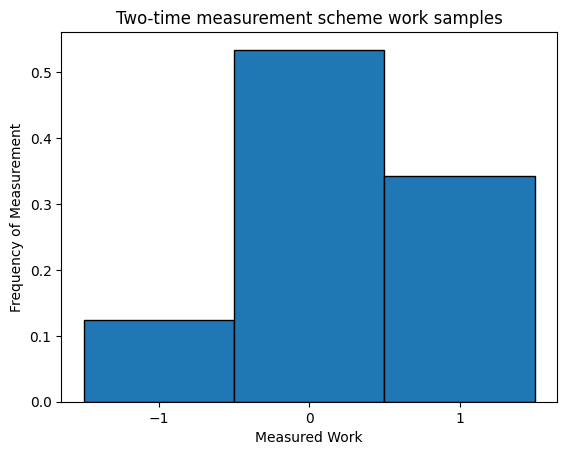

In [11]:
bin_edges = [-1.5, -0.5, 0.5, 1.5]
plt.hist(work_samples, bins=bin_edges, edgecolor='black', density=True, )
plt.title('Two-time measurement scheme work samples')
plt.xticks([-1, 0, 1])
plt.xlabel('Measured Work')
plt.ylabel('Frequency of Measurement')
plt.show()

# Computing the Jarzynski equality

In [13]:
print('<e^{-βW}> = ', np.mean(np.exp(-beta*work_samples)))
print('e^{-βΔF} = ', np.exp(-beta * delta_F))

<e^{-βW}> =  0.996881715609555
e^{-βΔF} =  1.0


We have computed $\overline{e^{-\beta W}} = 0.997$ and $e^{-\beta\Delta F}=1$, which is close enough to say we have demonstrated the Jarzynski relation in quantum mechanics.